# Laboratorio 2 - Detección de Spam

## Universidad del Valle de Guatemala

## Security Data Science

#### Integrantes:
* Oscar Estrada
* Andrés de la Roca

In [36]:
import pandas as pd
import numpy as np
import nltk
import re
import unicodedata
import contractions
import textsearch
import matplotlib
import pylab as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc


## **Parte 1 - Ingeniería de Características**

#### Exploración de Datos y Pre-Procesamiento

In [9]:
# Carga de datos
df = pd.read_csv('spam.csv', encoding='latin-1')

df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [10]:
# Unir las columnas v2, Unnamed: 2, Unnamed: 3 y Unnamed: 4
df['v2'] = df['v2'] + ' ' + df['Unnamed: 2'].fillna('') + ' ' + df['Unnamed: 3'].fillna('') + ' ' + df['Unnamed: 4'].fillna('')

# Drop Unnamed: 2, Unnamed: 3 and Unnamed: 4
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
# Hacer minúsculas los mensajes de v2
df['v2'] = df['v2'].str.lower()

df

,v1,v2
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will ì_ b going to esplanade fr home?
5569,ham,"pity, * was in mood for that. so...any other s..."
5570,ham,the guy did some bitching but i acted like i'd...


In [12]:
# Remover acentos
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

df['v2'] = df['v2'].apply(remove_accents)

df

,v1,v2
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will i_ b going to esplanade fr home?
5569,ham,"pity, * was in mood for that. so...any other s..."
5570,ham,the guy did some bitching but i acted like i'd...


In [13]:
# Remover caracteres especiales, numeros y simbolos
def remove_special_chars(text):
    return re.sub(r'[^a-z\s]', '', text)

df['v2'] = df['v2'].apply(remove_special_chars)

df

,v1,v2
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the nd time we have tried contact u u...
5568,ham,will i b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggest...
5570,ham,the guy did some bitching but i acted like id ...


In [14]:
# Corregir texto
def expand_contractions(text):
    return contractions.fix(text)

df['v2'] = df['v2'].apply(expand_contractions)

df

,v1,v2
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif you oni
2,spam,free entry in a wkly comp to win fa cup final...
3,ham,you dun say so early hor you c already then sa...
4,ham,nah i do not think he goes to usf he lives aro...
...,...,...
5567,spam,this is the nd time we have tried contact you...
5568,ham,will i b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggest...
5570,ham,the guy did some bitching but i acted like id ...


In [15]:
# Renombrar columnas
df = df.rename(columns={'v1': 'label', 'v2': 'message'})

In [16]:
nltk.download('punkt')
df['message'] = df.apply(lambda row: nltk.word_tokenize(row['message']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
df

,label,message
0,ham,"[go, until, jurong, point, crazy, available, o..."
1,ham,"[ok, lar, joking, wif, you, oni]"
2,spam,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,"[you, dun, say, so, early, hor, you, c, alread..."
4,ham,"[nah, i, do, not, think, he, goes, to, usf, he..."
...,...,...
5567,spam,"[this, is, the, nd, time, we, have, tried, con..."
5568,ham,"[will, i, b, going, to, esplanade, fr, home]"
5569,ham,"[pity, was, in, mood, for, that, soany, other,..."
5570,ham,"[the, guy, did, some, bitching, but, i, acted,..."


In [18]:
# Stop words
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    return [word for word in text if word not in stopword_list]

df['message'] = df['message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
df

,label,message
0,ham,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,"[ok, lar, joking, wif, oni]"
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,"[dun, say, early, hor, c, already, say]"
4,ham,"[nah, think, goes, usf, lives, around, though]"
...,...,...
5567,spam,"[nd, time, tried, contact, pound, prize, claim..."
5568,ham,"[b, going, esplanade, fr, home]"
5569,ham,"[pity, mood, soany, suggestions]"
5570,ham,"[guy, bitching, acted, like, id, interested, b..."


In [20]:
ps = PorterStemmer()

def stemming(text):
    return [ps.stem(word) for word in text]

df['message'] = df['message'].apply(stemming)

In [21]:
# Lemmatization
nltk.download('wordnet')
wnl = WordNetLemmatizer()

def lemmatization(text):
    return [wnl.lemmatize(word) for word in text]

df['message'] = df['message'].apply(lemmatization)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [22]:
df

,label,message
0,ham,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,"[ok, lar, joke, wif, oni]"
2,spam,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,"[dun, say, earli, hor, c, alreadi, say]"
4,ham,"[nah, think, goe, usf, live, around, though]"
...,...,...
5567,spam,"[nd, time, tri, contact, pound, prize, claim, ..."
5568,ham,"[b, go, esplanad, fr, home]"
5569,ham,"[piti, mood, soani, suggest]"
5570,ham,"[guy, bitch, act, like, id, interest, buy, som..."


In [23]:
# Remover palabras de longitud menor a 3
def remove_short_words(text):
    return [word for word in text if len(word) > 2]

df['message'] = df['message'].apply(remove_short_words)

#### Representación de texto

In [24]:
# Normalizar texto
def normalize_text(text):
    return ' '.join(text)

df['message'] = df['message'].apply(normalize_text)

In [25]:
df

,label,message
0,ham,jurong point crazi avail bugi great world buff...
1,ham,lar joke wif oni
2,spam,free entri wkli comp win cup final tkt may tex...
3,ham,dun say earli hor alreadi say
4,ham,nah think goe usf live around though
...,...,...
5567,spam,time tri contact pound prize claim easi call p...
5568,ham,esplanad home
5569,ham,piti mood soani suggest
5570,ham,guy bitch act like interest buy someth next we...


Spam = 1
Ham = 0

In [26]:
# Reemplazar spam por 1 y ham por 0
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

In [27]:
df

,label,message
0,0,jurong point crazi avail bugi great world buff...
1,0,lar joke wif oni
2,1,free entri wkli comp win cup final tkt may tex...
3,0,dun say earli hor alreadi say
4,0,nah think goe usf live around though
...,...,...
5567,1,time tri contact pound prize claim easi call p...
5568,0,esplanad home
5569,0,piti mood soani suggest
5570,0,guy bitch act like interest buy someth next we...


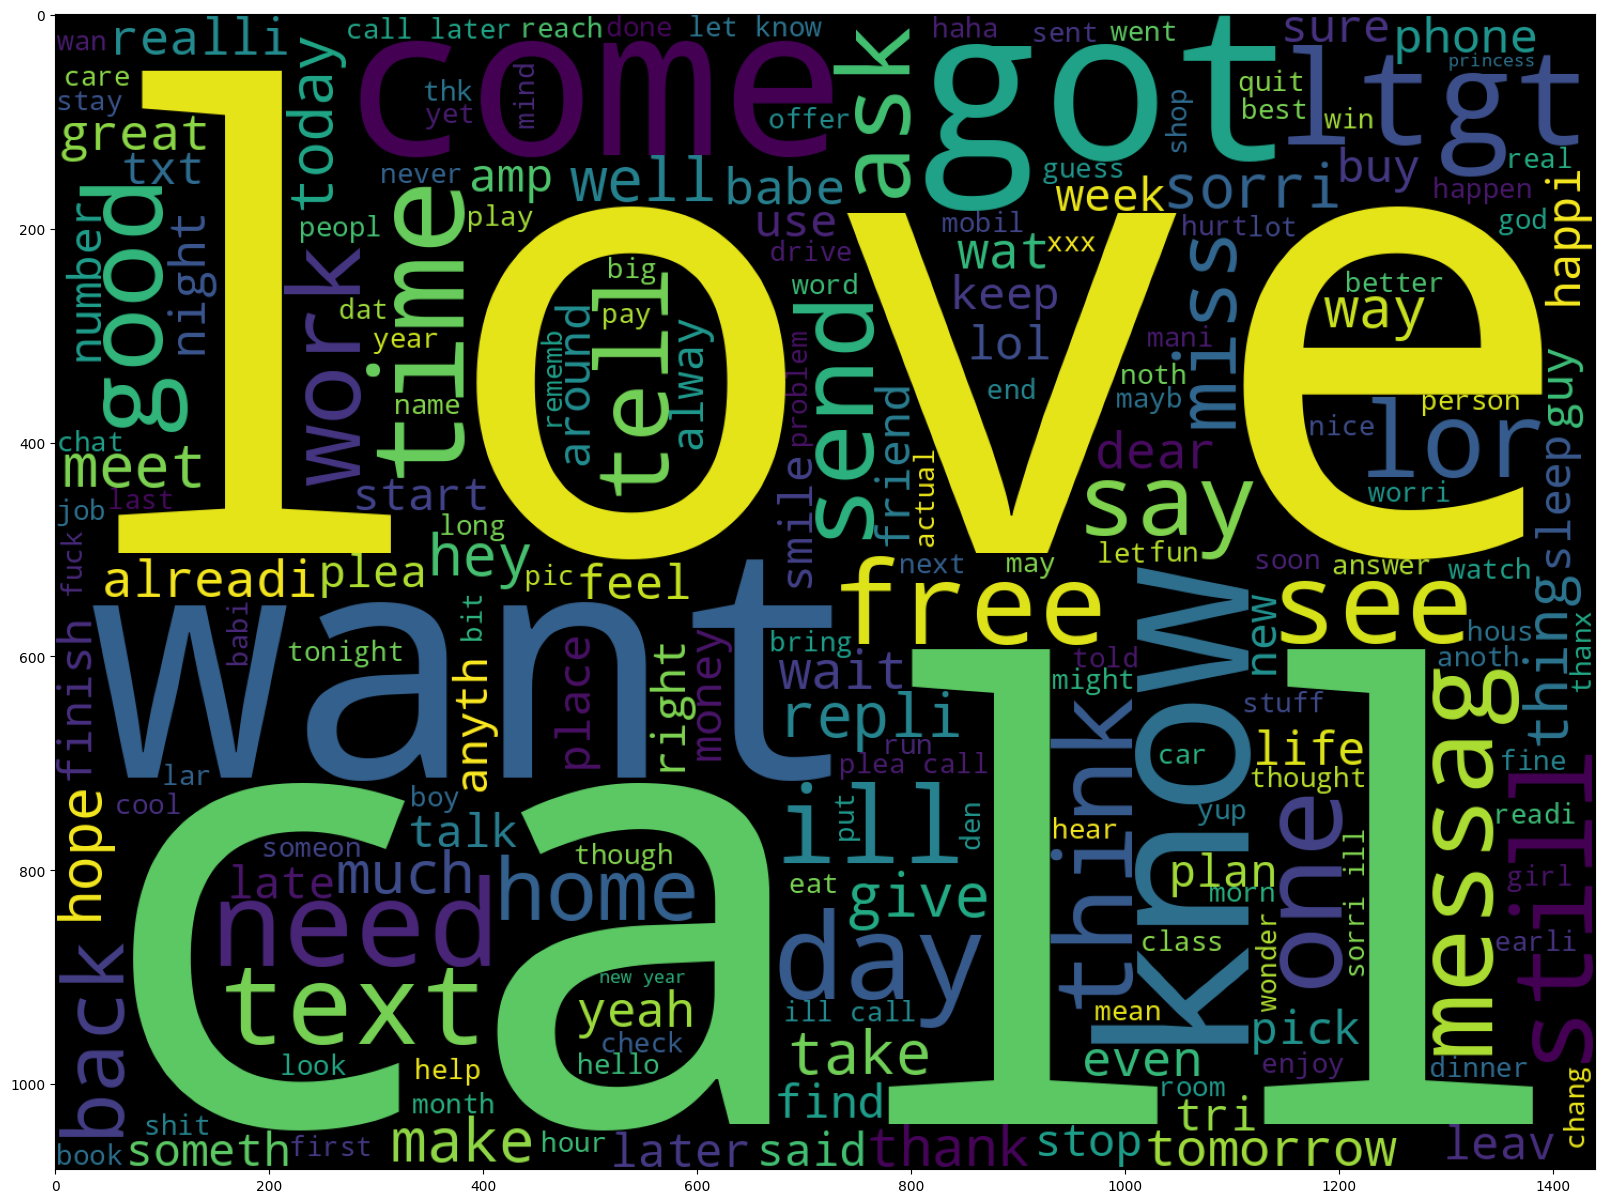

In [28]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(df['message']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)

### Modelo BoG

In [29]:
bv = CountVectorizer(ngram_range=(1, 2))
bv_matrix = bv.fit_transform(df['message'])

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
BoG_df = pd.DataFrame(bv_matrix, columns=vocab)
BoG_df

,aah,aah bless,aah cuddl,aah speak,aaniy,aaniy pudunga,aaooooright,aaooooright work,aathilov,aathilov lot,...,zoe hit,zoe join,zogtoriu,zogtoriu iaov,zoom,zoom cine,zouk,zouk nichol,zyada,zyada kisi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Mostrar las palabras más frecuentes
word_freq = BoG_df.sum(axis=0)
word_freq = word_freq.sort_values(ascending=False)
word_freq

call              657
get               451
know              305
come              300
love              286
                 ... 
home tomorrow       1
home thanksgiv      1
home super          1
home stuff          1
zyada kisi          1
Length: 33623, dtype: int64

### TF-IDF

In [31]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df['message'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
tfIDF_df = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
tfIDF_df

,aah,aaniy,aaooooright,aathilov,aathiwher,aaward,abbey,abdomen,abeg,abel,...,zebra,zed,zero,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Mostrar las palabras más frecuentes
word_freq = tfIDF_df.sum(axis=0)
word_freq = word_freq.sort_values(ascending=False)

word_freq

call            133.28
get              94.23
come             84.07
ill              75.44
know             71.07
                 ...  
shivratri         0.10
companion         0.10
psychologist      0.10
athlet            0.10
psychiatrist      0.10
Length: 6869, dtype: float64

## **Parte 2 - Implementación del modelo**

#### Modelo con BoG

Accuracy: 0.9736842105263158

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       730
           1       1.00      0.79      0.88       106

    accuracy                           0.97       836
   macro avg       0.99      0.90      0.93       836
weighted avg       0.97      0.97      0.97       836

Confusion Matrix:
[[730   0]
 [ 22  84]]

Precision: 1.0
Recall: 0.7924528301886793


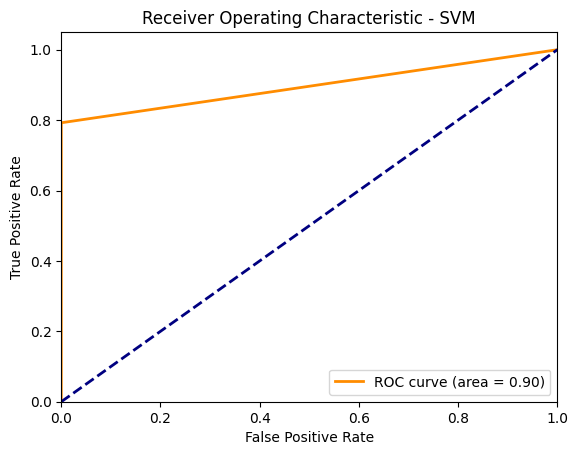

In [33]:
X = BoG_df # Caracteristicas
y = df['label'] # Variable objetivo

X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.214285714, random_state=42)

# Se implementa un SVM debido a la cantidad de datos y tipo de procesamiento.
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svm))

# Matriz de confusión
conf_matrix_svm = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

# Precision y Recall
precision_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[0, 1])
recall_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[1, 0])
print("\nPrecision:", precision_svm)
print("Recall:", recall_svm)

# Curva ROC y AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.show()


Accuracy on Test Set: 0.972488038277512

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1453
           1       0.99      0.79      0.88       219

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672

Confusion Matrix on Test Set:
[[1452    1]
 [  45  174]]

Precision: 0.9942857142857143
Recall: 0.7945205479452054


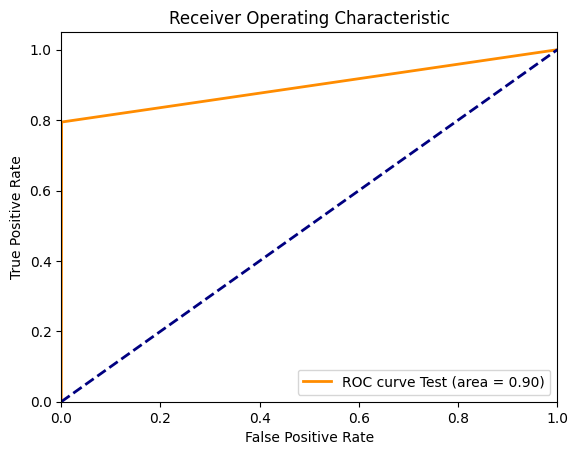

In [34]:
y_pred_test = svm_model.predict(X_test)

print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(conf_matrix)

# Precision y Recall
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("\nPrecision:", precision)
print("Recall:", recall)

# Curva ROC y AUC
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, y_pred_test)
roc_auc_t = auc(fpr_t, tpr_t)

plt.figure()
lw = 2
plt.plot(fpr_t, tpr_t, color='darkorange', lw=lw, label='ROC curve Test (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Los resultados obtenidos con el enfoque de Bag of Words (BoG) son bastante buenos, con un alto nivel de precisión y exactitud general en la clasificación. Con una precisión global del 97.25%, el modelo demuestra una capacidad sólida para distinguir entre mensajes de spam y no spam. La matriz de confusión muestra que el modelo cometió solo un error al clasificar los mensajes, clasificando incorrectamente un mensaje legítimo como spam. Sin embargo, el modelo logró identificar la gran mayoría de los mensajes de spam, como se refleja en una alta tasa de recall del 79.45%. Esto significa que el modelo tiene una buena capacidad para encontrar la mayoría de los mensajes de spam presentes en el conjunto de datos. Sin embargo, vale la pena señalar que la precisión del modelo para detectar mensajes de spam es ligeramente menor en comparación con su precisión para identificar mensajes legítimos, lo que se refleja en un valor de recall más bajo para la clase de spam. Esto sugiere que hay margen para mejorar la capacidad del modelo para identificar con mayor precisión los mensajes de spam, especialmente si se prioriza la reducción de los falsos positivos.

#### Modelo con TF-IDF

Accuracy: 0.9677033492822966

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       730
           1       0.94      0.79      0.86       106

    accuracy                           0.97       836
   macro avg       0.96      0.89      0.92       836
weighted avg       0.97      0.97      0.97       836

Confusion Matrix:
[[725   5]
 [ 22  84]]

Precision: 0.9438202247191011
Recall: 0.7924528301886793


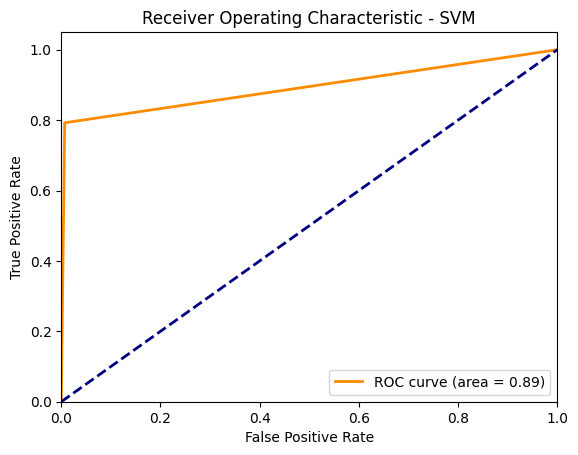

In [35]:
X = tfIDF_df # Caracteristicas
y = df['label'] # Variable objetivo

X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.214285714, random_state=42)

# Se implementa un SVM debido a la cantidad de datos y tipo de procesamiento.
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svm))

# Matriz de confusión
conf_matrix_svm = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

# Precision y Recall
precision_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[0, 1])
recall_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[1, 0])
print("\nPrecision:", precision_svm)
print("Recall:", recall_svm)

# Curva ROC y AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.show()


Accuracy on Test Set: 0.9700956937799043

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1453
           1       0.97      0.79      0.87       219

    accuracy                           0.97      1672
   macro avg       0.97      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672

Confusion Matrix on Test Set:
[[1448    5]
 [  45  174]]

Precision: 0.9720670391061452
Recall: 0.7945205479452054


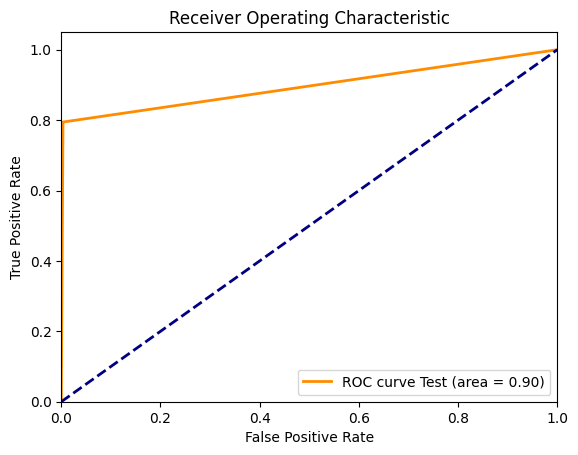

In [37]:
y_pred_test = svm_model.predict(X_test)

print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(conf_matrix)

# Precision y Recall
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("\nPrecision:", precision)
print("Recall:", recall)

# Curva ROC y AUC
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, y_pred_test)
roc_auc_t = auc(fpr_t, tpr_t)

plt.figure()
lw = 2
plt.plot(fpr_t, tpr_t, color='darkorange', lw=lw, label='ROC curve Test (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Los resultados con TF-IDF también son bastante buenos. Con una precisión del 97.01%, el modelo tiene una sólida capacidad para distinguir entre spam y mensajes legítimos. Cometió solo cinco errores al clasificar mensajes, de los cuales cuatro fueron falsos positivos, es decir, mensajes legítimos clasificados como spam. Sin embargo, al igual que con el modelo BoG, TF-IDF logró identificar la mayoría de los mensajes de spam con un 79.45% de acierto. Esto sugiere que, aunque ambos modelos tienen un desempeño similar, hay margen para mejorar la capacidad de TF-IDF para reducir los falsos positivos y mejorar aún más su precisión en la detección de spam. En general, TF-IDF muestra un rendimiento sólido, pero como siempre, hay espacio para ajustes y mejoras adicionales.

## **Discusión**

**¿Qué error es más “aceptable”: dejar pasar un SMS de SPAM (falso negativo) o bloquear un SMS legítimo (falso positivo)? Justifique su respuesta.** 

Es más aceptable dejar pasar un SMS de spam (falso negativo) que bloquear un SMS legítimo (falso positivo). Esto ya que un falso positivo puede resultar en la pérdida de información importante o en que el usuario puede perder mensajes legítimos, mientras que un falso negativo simplemente significa que se ha permitido pasar un mensaje de spam. Y como es en nuestro día a día, solo lo ignoramos o eliminamos finalmente.

**Compare los valores para cada modelo de representación numérico. En base a la respuesta de la primera pregunta ¿Qué modelo de representación numérica produjo el mejor resultado, BoG o TF-IDF? ¿Cuál o cuáles son las razones por las que dicho modelo se comportó de mejor manera?**

BoG tiene un rendimiento ligeramente mejor en términos de accuracy (+0.0024) y precision (+0.0222), por lo que podríamos concluir que BoG produjo el mejor resultado en este caso particular. El mejor rendimiento del modelo BoG podría atribuirse a varias razones, incluyendo la eficacia de la representación de texto y las características del conjunto de datos. Además, tomemos en cuenta que en el modo de presentación del BoG es ocurrencia, mientras que TF-IDF es lo mismo pero de forma relativa.

**En base a la exploración de datos e ingeniería de características que realizó en el primer y este laboratorio, ¿qué consejos le daría a un familiar que le solicita ayuda para detectar si un email o SMS es phishing o no? ¿En qué características de una URL/email podría fijarse su familiar para ayudarlo a detectar un potencial phishing?**

Algo así a simple vista podría ser el revisar bien la URL en busca de características raras: Largo, caracteres especiales, letras cambiadas o signos agregados demás. Asímismo, revisar redacción de formato, confirmar el enlace es de algún HTTPS, o incluso, verificar como palabras más frecuentes como la que se obtuvo en este caso "call, get know, need, share, etc". Pero principalmente, se deben evitar también las solicitudes urgentes de información personal o confidencial, ya que las empresas legítimas rara vez las hacen a través de correo electrónico o mensajes de texto. Ante cualquier duda consultarlo por llamada con la agencia oficial, persona o alguien que sabe que me sabría decir si es de confianza o no.

**Si detectamos una URL o email/SMS de phishing, ¿qué podemos hacer para detener su distribución?**

Principalmente el detener cualquier interacción con el contenido sospechoso (no haciendo click a enlaces, respondiendo a solicitudes, etc). Seguidamente se puede hacer un reporte como spam a la plataforma donde se recibió, siendo así una forma de poder ayudar a la categorización de estos. Por último, se puede contactar a la persona u organización de donde se proviene el fraude y avisar respecto a lo que está ocurriendo para que puedan mantenerse informados de lo que sucede y puedan hacer algo al respecto. Nunca está de más alertar a otras personas para enseñarles o prevenirles caer en esto.